In [1]:
#importing the required libraries
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import cv2
import os

import glob

import numpy as np
import pandas as pd

In [2]:
data_dir = "D:/usersss/animals-detection-images-dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

all_train_subdir = glob.glob(train_dir + "/*")
all_test_subdir = glob.glob(test_dir + "/*")

In [3]:
data_dir = "D:/usersss/animals-detection-images-dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Get a list of all subdirectories in the train directory
all_train_subdir = glob.glob(train_dir + "/*")

# Count the number of subdirectories to get the number of classes
num_classes = len(all_train_subdir)

print("Number of classes in the train dataset:", num_classes)

Number of classes in the train dataset: 80


In [4]:
#Checking the number of classes in the datasets
train_classes=[os.path.basename(pp) for pp in all_train_subdir]
test_classes=[os.path.basename(pp) for pp in all_test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(train_classes), len(test_classes)))

There is 80 classes in train dataset, and 80 classes in test dataset


In [5]:
train_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_train_subdir}
test_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in all_test_subdir}
# all_image_counts=train_image_counts.copy()
# all_image_counts={k:all_image_counts[k]+test_image_counts[k] for k in all_image_counts.keys()}
train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df.head()

,train,test
Bear,87,39
Brown bear,108,39
Bull,47,73
Butterfly,1875,170
Camel,67,27


In [6]:
img_path = []
label = []
test_path = []
test_label = []
label_dict = {label : index for index, label in enumerate(train_classes)}

for subdir in all_train_subdir:
    image_files = glob.glob(os.path.join(subdir, "*.jpg"))
    for image_file in image_files:
        temp_img_path = image_file
        temp_label = os.path.basename(os.path.dirname(image_file))
        img_path.append(temp_img_path)
        label.append(temp_label)
               

for subdir in all_test_subdir:
    image_files = glob.glob(os.path.join(subdir, "*.jpg"))
    for image_file in image_files:
        temp_img_path = image_file
        temp_label = os.path.basename(os.path.dirname(image_file))
        test_path.append(temp_img_path)
        test_label.append(temp_label)

In [7]:
import torchvision.transforms.functional as TF

def resize_img(image, target_size = (256, 256)):
    image_new = TF.resize(image, target_size)
    return image_new

In [8]:
# normalization
transform = transforms.Compose(
            [transforms.ToTensor(), # change to torch.tensor
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean, distribution

batch_size = 64

class CustomDataset(data.Dataset):
    def __init__(self, img_path, label):
        super(CustomDataset, self).__init__()
        
        self.img_path = img_path
        self.label = label
        
    def __getitem__(self, index):
        self.image = np.array(cv2.flip(cv2.imread(self.img_path[index]),0))
        self.image = transform(self.image)
        self.image = resize_img(torch.flip(self.image, [0, 1]))
        self.label_idx = torch.tensor(label_dict[self.label[index]])
        return self.image, self.label_idx
    
    def __len__(self):
        return len(self.img_path)
    
train_dataset = CustomDataset(img_path, label)
test_dataset = CustomDataset(test_path, test_label)

C:\Users\pierre\anaconda\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


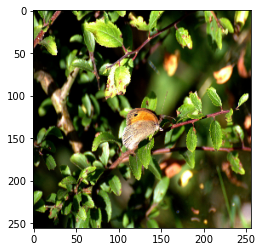

'Butterfly'

In [9]:
selected_image, selected_label = train_dataset[901]
selected_image = selected_image / 2 + 0.5     # denormalize
npimg = selected_image
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
train_classes[selected_label.item()]

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=os.cpu_count())

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expension = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*BasicBlock.expension, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        def forward(self, x):
            x = self.residual_block(x) + self.shortcut(x)
            x = self.relu(x)
            return x


class BottleNeck(nn.Module):
    expension = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        
        self.residual_block(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*BottleNeck.expension, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels*BottleNeck.expension)
        )
        
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()
        
        if stride != 1 or in_channels != out_channels * BottleNeck.expension:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expension, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expension)
            )
            
    def forward(self, x):
        x = self.residual_block(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [15]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=80, init_weights=True):
        super().__init__()
        
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2, padding=1)
        )
        
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.expension, num_classes)
        
        # weights inittialization
        if init_weights:
            self._initialize_weights()
        
    def _make_layer(self, block, out_channels, num_block, stride):
        strides = [stride] + [1] * (num_block - 1) 
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expension
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [16]:
#Loss Function
import torch.optim as optim

model = resnet34()
learning_rate = 0.005

loss_fn = nn.CrossEntropyLoss() # multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 3
iterations = 100

# pytorch.
for epoch in range(epochs):
    train_loss = 0.0

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data

        # gradient 
        optimizer.zero_grad()

        # feed-forward
        outputs = model(inputs)  # forward call.
        loss = loss_fn(outputs, labels)  # cross-entropy loss 

        # backprop
        loss.backward()  # local gradient loss backprop
        optimizer.step() # weight update
        
          # iteration loss
        train_loss += loss.item()  # loss summation
        if i % iterations == iterations - 1:
            print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, train_loss/iterations))
            train_loss = 0.0  # loss.

print("Training is complete")


In [ ]:
# save model
torch.save(model.state_dict(), "AnimalDet_model_1.pth")